In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
import random
from sklearn.metrics import mean_squared_error, mean_absolute_error
from kerastuner.tuners import RandomSearch

## Preparing Data

In [32]:
# Reading in data
crime = pd.read_csv('.\data\Crimes.csv')
weather = pd.read_csv('.\data\weather.csv')
holidays = pd.read_csv('.\data\holidays.csv')
income = pd.read_csv('.\data\med_income.csv')

In [33]:
# date to datetime, creating year column
crime['Date'] = pd.to_datetime(crime['Date']).dt.date
crime['Year'] = pd.to_datetime(crime['Date']).dt.year

# defining violent crimes
violent = ['HOMICIDE', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 
           'CRIM SEXUAL ASSAULT', 'ASSAULT', 'ROBBERY', 'HUMAN TRAFFICKING']

# filtering out earlier than 2010, non-violent crimes
crime = crime[(crime['Year'] > 2009) & (crime['Primary Type'].isin(violent))]

In [34]:
# creating count of crimes per day
count = pd.DataFrame(crime.groupby('Date').size().reset_index(name = 'Count'))

In [35]:
# creating year, month, day, weekday columns
count['Year'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.year)
count['Weekday'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.dayofweek)
count['Month'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.month)
count['Day'] = pd.to_numeric(pd.to_datetime(count['Date']).dt.day)

In [36]:
# weather date, sunlight in minutes columns
weather = weather.rename(columns = {'datetime': 'Date'})
weather['Date'] = pd.to_datetime(weather['Date']).dt.date
weather['sunrise'] = (pd.to_datetime(weather['sunrise']))
weather['sunset'] = (pd.to_datetime(weather['sunset']))
weather['sunlight'] = (weather['sunset'] - weather['sunrise']) / pd.Timedelta(minutes = 1)

# holidays date column
holidays['Date'] = (pd.to_datetime(holidays['Date']).dt.date)

# merging datasets based on date (or year for income)
df = pd.merge(count, weather, how = 'left', on = ['Date'])
df = pd.merge(df, holidays, how = 'left', on = ['Date'])
df = pd.merge(df, income, how = 'left', on = ['Year'])

In [37]:
# dropping unnecessary columns
cols = ['description', 'icon', 'stations', 'Day of Week', 'sunrise',
        'sunset', 'name']

df = df.drop(columns = cols)

In [38]:
df.columns

Index(['Date', 'Count', 'Year', 'Weekday', 'Month', 'Day', 'tempmax',
       'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew',
       'humidity', 'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex',
       'severerisk', 'moonphase', 'conditions', 'sunlight', 'Holiday',
       'Med_Income'],
      dtype='object')

In [39]:
# numeric and categorical variables
num = df.dtypes[df.dtypes != 'object'].index.to_list()[1:]
cat = df.dtypes[df.dtypes == 'object'].index.to_list()[1:]

In [40]:
# x and y matrices
X = df[num]
y = df['Count']

In [69]:
X.shape

(4803, 30)

In [41]:
# splitting into testing/training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Neural Network

In [42]:
# Standardizing the features

# categorical and numeric
# ct = ColumnTransformer([
#     # ('encoder', OneHotEncoder(), cat),
#     ('scaler', StandardScaler(), num)
# ], remainder='passthrough')
# X_train_encoded = ct.fit_transform(X_train)
# X_test_encoded = ct.transform(X_test)
# X_train_encoded = np.array(X_train_encoded).astype('float32')
# X_test_encoded = np.array(X_test_encoded).astype('float32')

# just numeric
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = np.array(X_train_scaled).astype('float32')
X_test_scaled = np.array(X_test_scaled).astype('float32')

In [43]:
# # Define and compile the model
# model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1, activation='linear')
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# # Train the model
# history = model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2, verbose=0)

# # Evaluate the model
# _, mae = model.evaluate(X_train_scaled, y_test)

# print("Mean Absolute Error:", mae)

In [44]:
# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# NN model
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train_scaled.shape[1],)))
    for i in range(hp.Int('num_layers', 1, 5)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}', 32, 512, 32), activation='relu'))
        model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}', 0, 0.5, 0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse', metrics=['mae'])
    return model

In [46]:
# random search parameters
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='crime_model')

Reloading Tuner from my_dir\crime_model\tuner0.json


In [47]:
# finding best model
tuner.search(X_train_scaled, y_train, epochs=10, validation_split=0.2)

In [48]:
# best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print(best_hyperparameters)

In [68]:
print("Best Hyperparameters:")
print(f"- Number of Layers: {best_hyperparameters.get('num_layers')}")
for i in range(best_hyperparameters.get('num_layers')):
    print(f"  Layer {i+1}:")
    print(f"    Units: {best_hyperparameters.get(f'units_{i}')}")
    print(f"    Dropout: {best_hyperparameters.get(f'dropout_{i}')}")
print(f"- Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
- Number of Layers: 3
  Layer 1:
    Units: 384
    Dropout: 0.30000000000000004
  Layer 2:
    Units: 96
    Dropout: 0.1
  Layer 3:
    Units: 64
    Dropout: 0.1
- Learning Rate: 0.01


In [49]:
# fitting the model
best_model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
97/97 [==============================] - 1s 4ms/step - loss: 28.9340 - mae: 4.2848 - val_loss: 26.7164 - val_mae: 3.9987
Epoch 2/100
97/97 [==============================] - 0s 4ms/step - loss: 29.3848 - mae: 4.3123 - val_loss: 29.9552 - val_mae: 4.1928
Epoch 3/100
97/97 [==============================] - 0s 3ms/step - loss: 28.7077 - mae: 4.2577 - val_loss: 26.4526 - val_mae: 3.9863
Epoch 4/100
97/97 [==============================] - 0s 2ms/step - loss: 28.3011 - mae: 4.2251 - val_loss: 26.3698 - val_mae: 3.9811
Epoch 5/100
97/97 [==============================] - 0s 2ms/step - loss: 29.1028 - mae: 4.2812 - val_loss: 27.4300 - val_mae: 4.0214
Epoch 6/100
97/97 [==============================] - 0s 2ms/step - loss: 28.7765 - mae: 4.2414 - val_loss: 26.8054 - val_mae: 4.0021
Epoch 7/100
97/97 [==============================] - 0s 2ms/step - loss: 28.4695 - mae: 4.2288 - val_loss: 26.3061 - val_mae: 4.0318
Epoch 8/100
97/97 [==============================] - 0s 2ms/step - lo

In [50]:
# MAE and MSE
yhat = best_model.predict(X_train_scaled)
print(mean_squared_error(y_train, yhat))
print(mean_absolute_error(y_train, yhat))

121/121 [==============================] - 1s 5ms/step
26.80454378746771
4.090264413209088


## SHAP 

In [51]:
features = X.columns

In [52]:
# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [53]:
# Creating a SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

In [54]:
# exp = shap.Explanation(shap_values[:,:,1], 
#                        shap_values.base_values[:,1], 
#                        X, feature_names=features)

In [55]:
# shap.plots.waterfall(exp[100])

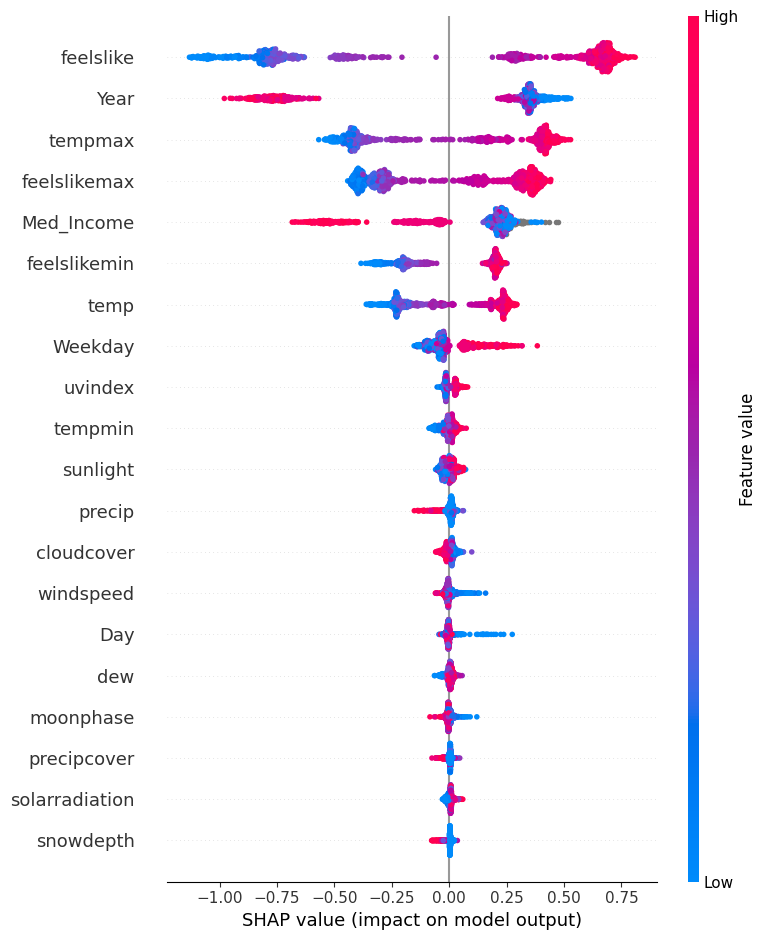

In [56]:
# Plotting SHAP values
shap.summary_plot(shap_values, X_test)